<a href="https://colab.research.google.com/github/Raashidh-Rizvi/Brain-Tumor-Detection/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# If you're on Colab, TensorFlow is preinstalled.
!nvidia-smi -L  # optional: shows GPU

import os, glob, itertools, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

IMG_SIZE   = 224     # good default for transfer learning
BATCH_SIZE = 32
VAL_SPLIT  = 0.2   # create a validation set from Training


GPU 0: Tesla T4 (UUID: GPU-fd3a2b8b-4fef-c4a9-4ec7-77b7aa5b1c5e)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# CHANGE THIS to your dataset root in Drive
DATA_ROOT = "/content/drive/MyDrive/BrainTumor"  # contains Training/ and Testing/

TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
TEST_DIR  = os.path.join(DATA_ROOT, "Testing")

assert os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR), "Check your paths."


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def count_images(root):
    data = []
    for split in ["Training", "Testing"]:
        split_dir = os.path.join(root, split)
        for cls in sorted(os.listdir(split_dir)):
            cls_dir = os.path.join(split_dir, cls)
            if os.path.isdir(cls_dir):
                n = len([p for p in glob.glob(cls_dir + "/*") if p.lower().endswith(('.png','.jpg','.jpeg'))])
                data.append((split, cls, n))
    df = pd.DataFrame(data, columns=["split", "class", "count"])
    return df

df_counts = count_images(DATA_ROOT)
df_counts


,split,class,count
0,Training,glioma,1321
1,Training,meningioma,1339
2,Training,notumor,1595
3,Training,pituitary,1457
4,Testing,glioma,300
5,Testing,meningioma,306
6,Testing,notumor,415
7,Testing,pituitary,300


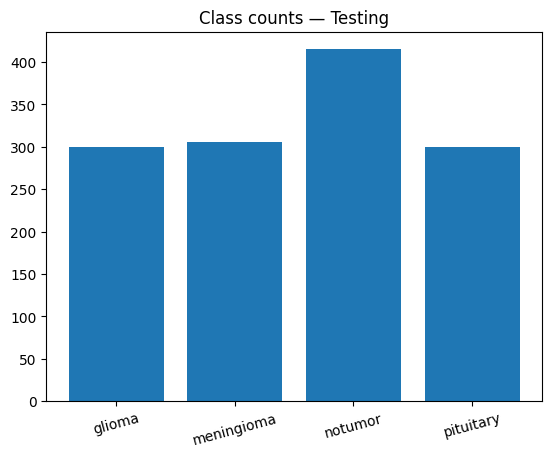

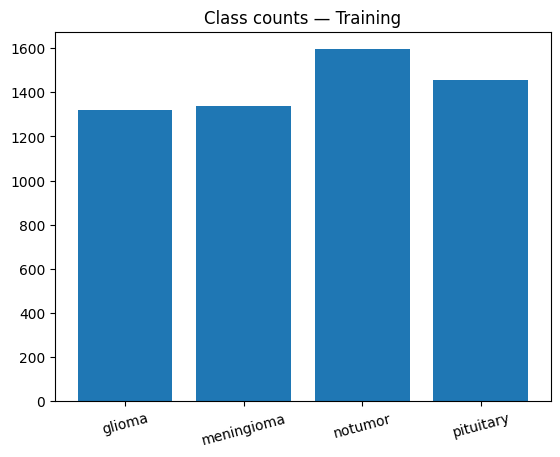

In [ ]:
# Bar chart: class distribution
for split, g in df_counts.groupby("split"):
    plt.figure()
    plt.title(f"Class counts — {split}")
    plt.bar(g["class"], g["count"])
    plt.xticks(rotation=15)
    plt.show()


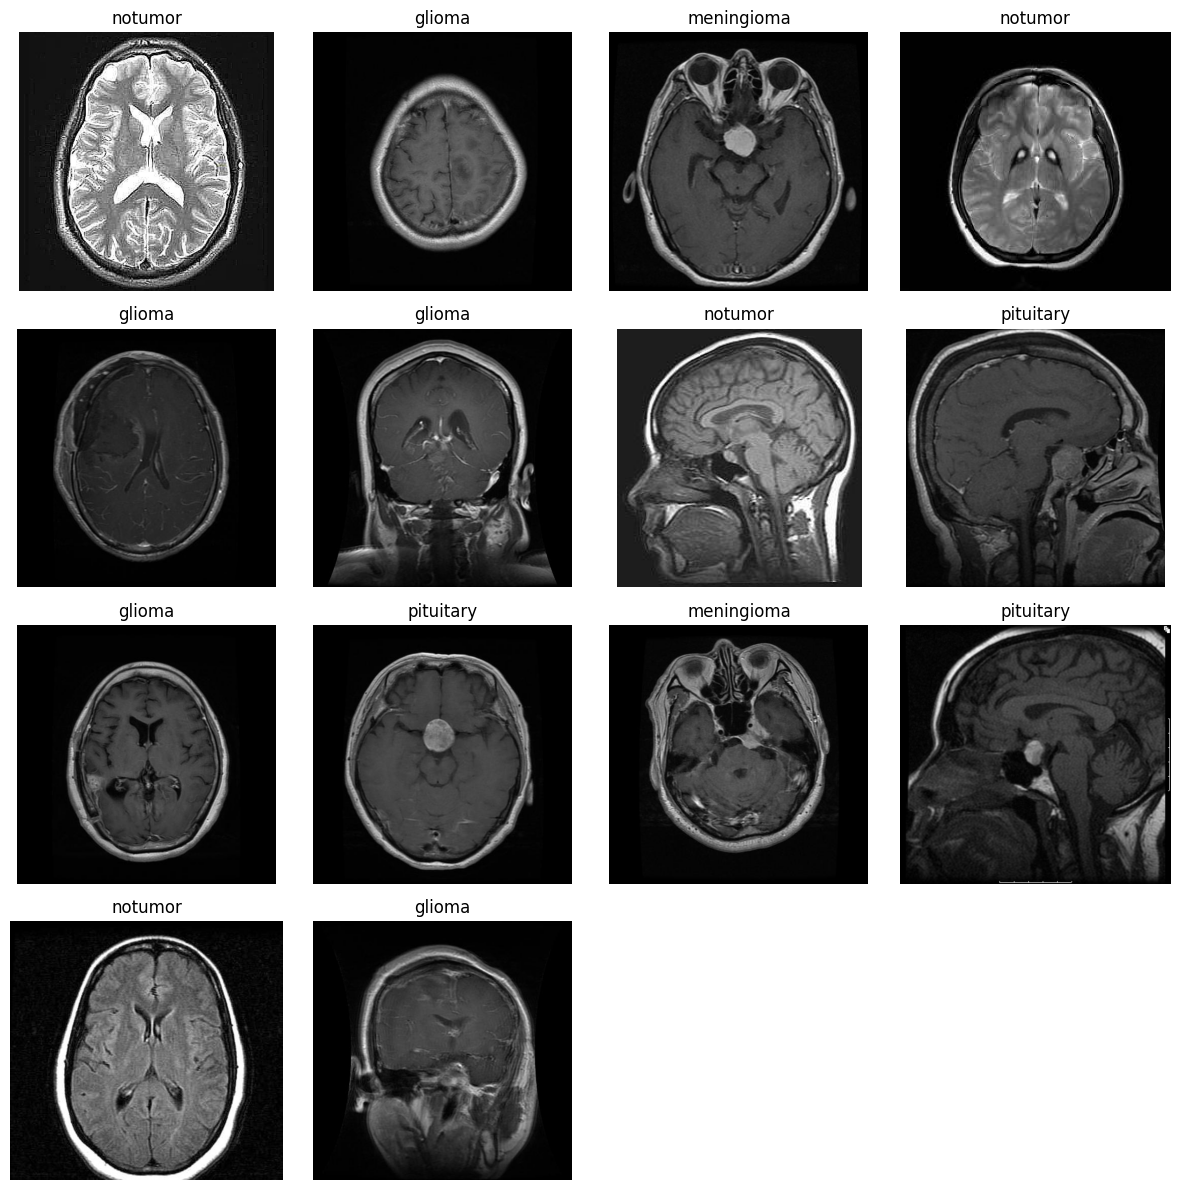

In [ ]:
# Peek a few random samples from Training
def show_samples(folder, n=12):
    paths = []
    for cls in sorted(os.listdir(folder)):
        p = os.path.join(folder, cls)
        if os.path.isdir(p):
            paths += [os.path.join(p, f) for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    random.shuffle(paths)
    paths = paths[:n]

    cols = 4
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(12, 3*rows))
    for i, p in enumerate(paths, 1):
        img = keras.utils.load_img(p)
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(os.path.dirname(p)))
    plt.tight_layout()
    plt.show()

show_samples(TRAIN_DIR, n=14)


In [ ]:
from PIL import Image

def find_corrupt_images(folder):
    bad = []
    for path in glob.glob(folder + "/**/*", recursive=True):
        if path.lower().endswith(('.png','.jpg','.jpeg')):
            try:
                with Image.open(path) as im:
                    im.verify()
            except Exception:
                bad.append(path)
    return bad

bad_files = find_corrupt_images(DATA_ROOT)
len(bad_files), bad_files[:5]


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',              # pairs with SparseCategoricalCrossentropy
    validation_split=VAL_SPLIT,
    subset='training',
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    validation_split=VAL_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    shuffle=False,                 # keep order for evaluation
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


In [ ]:
# Performance: cache & prefetch
def configure(ds, training=False):
    ds = ds.cache()
    if training:
        ds = ds.shuffle(1000, seed=SEED)
    return ds.prefetch(AUTOTUNE)

train_ds = configure(train_ds, training=True)
val_ds   = configure(val_ds)
test_ds  = configure(test_ds)


In [ ]:
# Extract integer labels from the raw training directory to compute weights
train_labels = []
for cls_idx, cls in enumerate(class_names):
    files = glob.glob(os.path.join(TRAIN_DIR, cls, "*"))
    train_labels += [cls_idx] * len(files)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=np.array(train_labels)
)
class_weights = {i:w for i, w in enumerate(class_weights)}
class_weights


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
], name="augmentation")

# EfficientNet expects [0,255] inputs; we'll scale to [0,1] first
rescale = layers.Rescaling(1./255)


In [ ]:
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet"
)
base.trainable = False  # freeze for warmup

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [ ]:
ckpt_path = "/content/brain_tumor_efficientnet.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1
    )
]


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
], name="augmentation")

# EfficientNet expects [0,255] inputs; we'll scale to [0,1] first
rescale = layers.Rescaling(1./255)


In [ ]:
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet"
)
base.trainable = False  # freeze for warmup

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [ ]:
ckpt_path = "/content/brain_tumor_efficientnet.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1
    )
]


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


In [ ]:
# Plot learning curves
def plot_history(h):
    plt.figure()
    plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.legend(); plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.show()

    plt.figure()
    plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

plot_history(history)


In [ ]:
# Unfreeze last ~30% of layers
base.trainable = True
for layer in base.layers[: int(0.7 * len(base.layers))]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # smaller LR for fine-tuning
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

plot_history(history_ft)


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


In [ ]:
# Predictions → classification report & confusion matrix
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred_proba = model.predict(test_ds)
y_pred = np.argmax(y_pred_proba, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
th = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > th else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/brain_tumor_model"
os.makedirs(SAVE_DIR, exist_ok=True)

model.save(os.path.join(SAVE_DIR, "model.keras"))  # Keras native format
with open(os.path.join(SAVE_DIR, "classes.txt"), "w") as f:
    for c in class_names:
        f.write(c + "\n")

print("Saved to:", SAVE_DIR)


In [ ]:
def predict_image(path):
  path ("/content/drive/MyDrive/BrainTumor/OIP (1)")

    img = keras.utils.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = keras.utils.img_to_array(img)[None, ...]   # shape (1, H, W, 3)
    x = x / 255.0
    proba = model.predict(x)[0]
    idx = np.argmax(proba)
    return class_names[idx], dict(zip(class_names, proba.round(4)))

# Example:
# pred, probs = predict_image("/content/drive/MyDrive/some_image.jpg")
# pred, probs
